# Full-datset

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

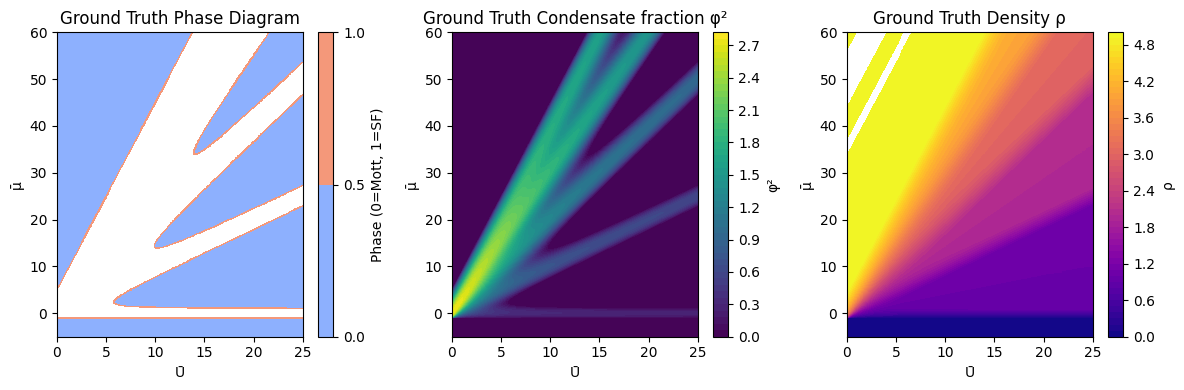

Epoch 1/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9878 - val_loss: 0.1340
Epoch 2/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9335 - val_loss: 0.2294
Epoch 3/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4816 - val_loss: 0.1660
Epoch 4/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3420 - val_loss: 0.0884
Epoch 5/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2805 - val_loss: 0.0824
Epoch 6/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2472 - val_loss: 0.0586
Epoch 7/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2235 - val_loss: 0.0506
Epoch 8/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2076 - val_loss: 0.0454
Epoch 9/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1956 - val_loss: 0.0430
Epoch 10/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1843 - val_loss: 0.0477
Epoch 11/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1699 - val_loss: 0.0432
Epoch 12/200
272/272 ━━━━━━━━━━━━━━━━━━━━

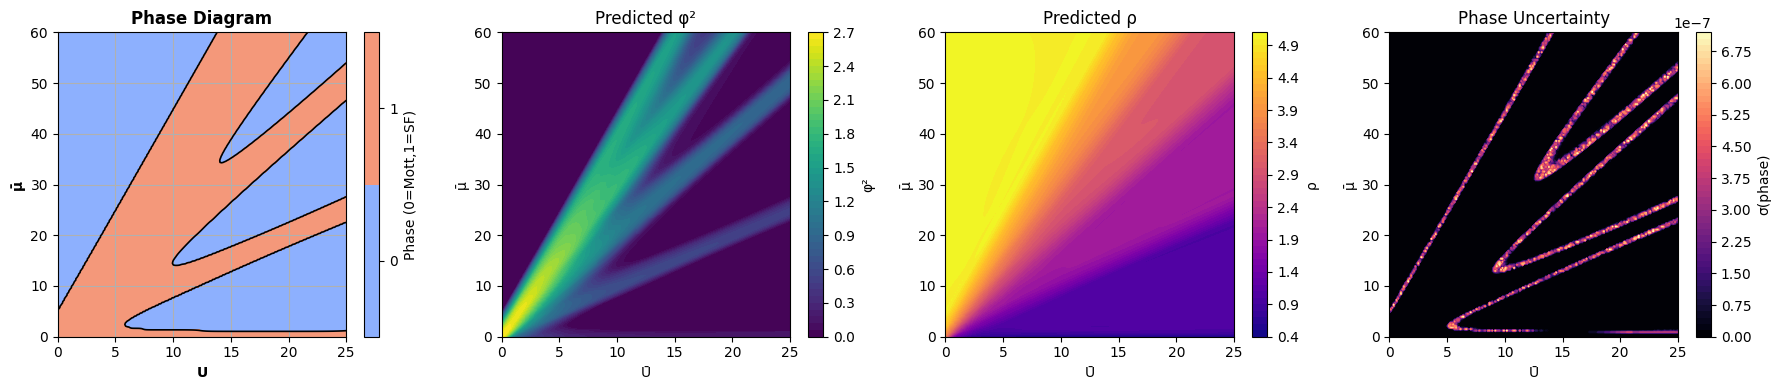

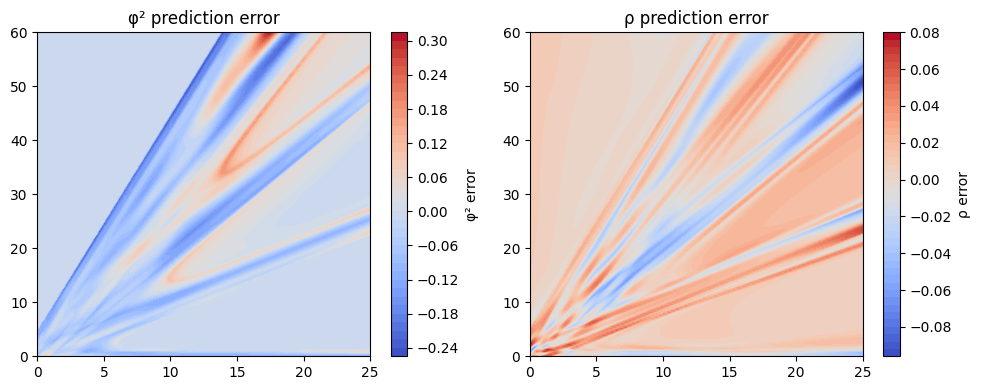

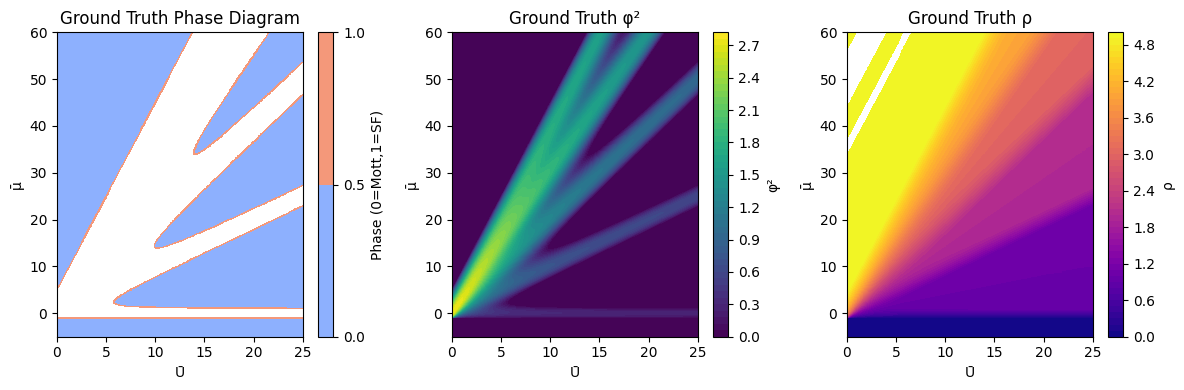


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9951    0.9933    0.9942     23172
           1     0.9908    0.9932    0.9920     16828

    accuracy                         0.9933     40000
   macro avg     0.9929    0.9933    0.9931     40000
weighted avg     0.9933    0.9933    0.9933     40000



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

# df_MI = df[
#     (df["Phi2"] < 1e-8) &
#     (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
# ]

# # --- pick deep SF (large phi2) ---
# df_SF = df[df["Phi2"] > 1e-2]

# # --- pick boundary (ambiguous region) ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
# ]

# ------------------------------
# Smart sampling strategy
# # ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# # n_MI = min(5000, len(df_MI))
# # n_SF = min(5000, len(df_SF))
# # n_boundary = min(10000, len(df_boundary))

# # n_MI = min(3000, len(df_MI))
# # n_SF = min(3000, len(df_SF))
# # n_boundary = min(6000, len(df_boundary))


# df_reduced = pd.concat([
#     df_MI.sample(n_MI, random_state=42),
#     df_SF.sample(n_SF, random_state=42),
#     df_boundary.sample(n_boundary, random_state=42)
# ])
# print(df)
# df_reduced = df_reduced.reset_index(drop=True)
# # Use reduced dataset
# df = df_reduced.reset_index(drop=True)
# print(df)


# print("Reduced dataset summary:")
# print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('Full-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# Full data extrapolated region U=40, MU=70

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

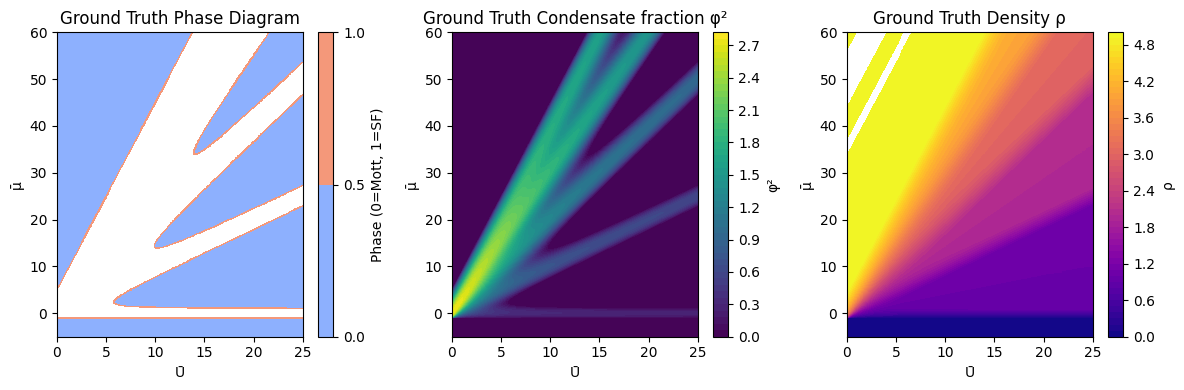

Epoch 1/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9869 - val_loss: 0.0773
Epoch 2/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7818 - val_loss: 0.1636
Epoch 3/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3859 - val_loss: 0.0845
Epoch 4/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2417 - val_loss: 0.0645
Epoch 5/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2041 - val_loss: 0.0447
Epoch 6/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1812 - val_loss: 0.0394
Epoch 7/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1594 - val_loss: 0.0425
Epoch 8/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1452 - val_loss: 0.0374
Epoch 9/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1337 - val_loss: 0.0400
Epoch 10/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1239 - val_loss: 0.0361
Epoch 11/200
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1150 - val_loss: 0.0337
Epoch 12/200
272/272 ━━━━━━━━━━━━━━━━━━━━

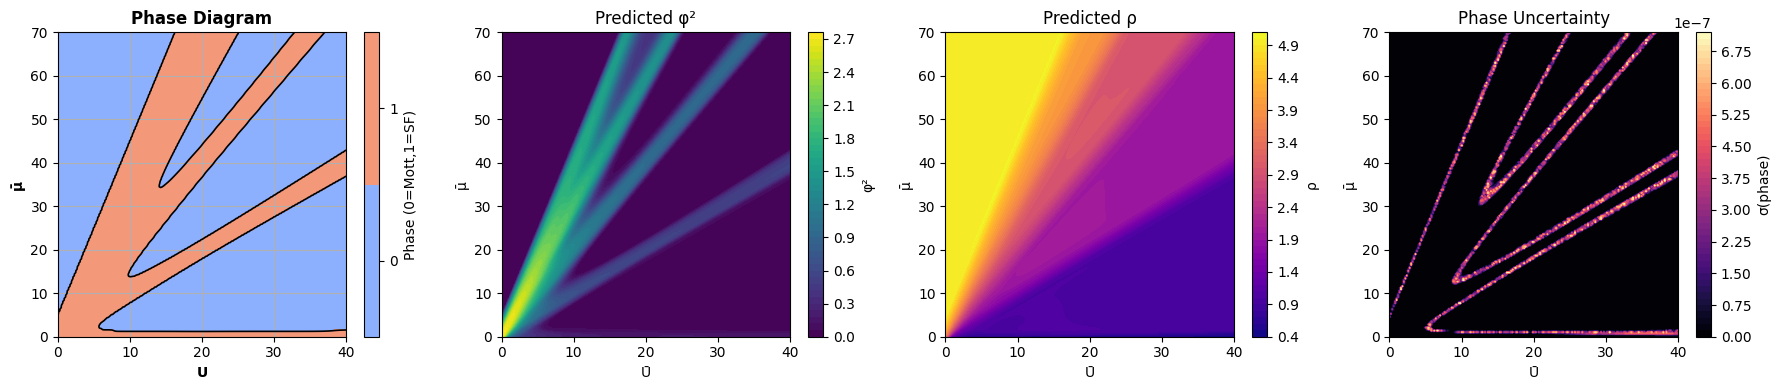

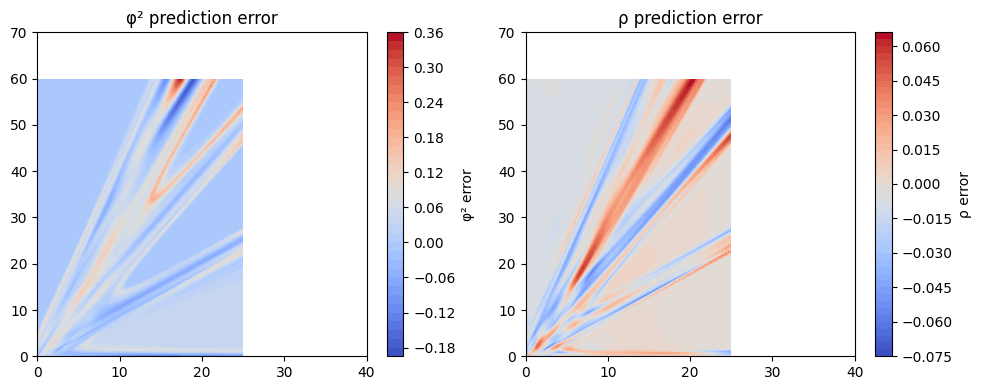

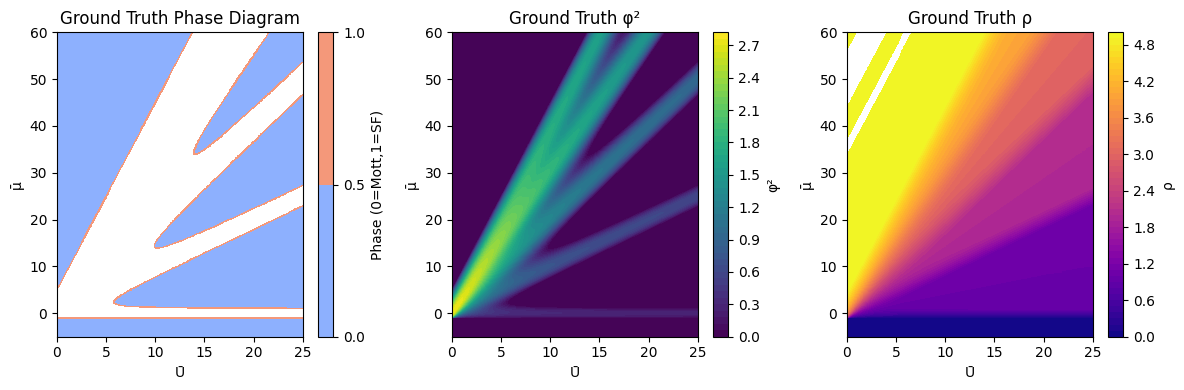


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9983    0.8765    0.9334     31000
           1     0.7004    0.9948    0.8221      9000

    accuracy                         0.9031     40000
   macro avg     0.8494    0.9356    0.8777     40000
weighted avg     0.9313    0.9031    0.9084     40000



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

# df_MI = df[
#     (df["Phi2"] < 1e-8) &
#     (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
# ]

# # --- pick deep SF (large phi2) ---
# df_SF = df[df["Phi2"] > 1e-2]

# # --- pick boundary (ambiguous region) ---
# df_boundary = df[
#     (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
# ]

# ------------------------------
# Smart sampling strategy
# # ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# # n_MI = min(5000, len(df_MI))
# # n_SF = min(5000, len(df_SF))
# # n_boundary = min(10000, len(df_boundary))

# # n_MI = min(3000, len(df_MI))
# # n_SF = min(3000, len(df_SF))
# # n_boundary = min(6000, len(df_boundary))


# df_reduced = pd.concat([
#     df_MI.sample(n_MI, random_state=42),
#     df_SF.sample(n_SF, random_state=42),
#     df_boundary.sample(n_boundary, random_state=42)
# ])
# print(df)
# df_reduced = df_reduced.reset_index(drop=True)
# # Use reduced dataset
# df = df_reduced.reset_index(drop=True)
# print(df)


# print("Reduced dataset summary:")
# print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('Full-extra-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 30k 

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

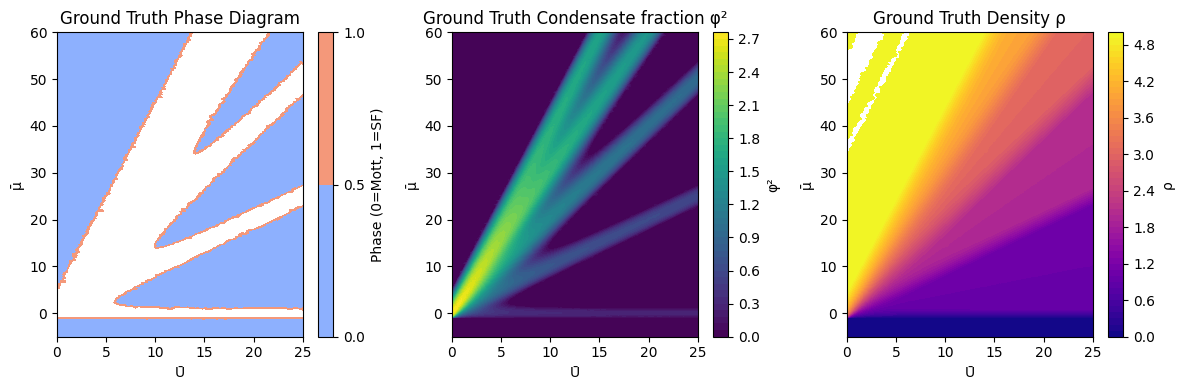

Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1644 - val_loss: 1.1167
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0593 - val_loss: 1.2615
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2967 - val_loss: 1.1804
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1025 - val_loss: 1.1160
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0234 - val_loss: 1.1049
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9599 - val_loss: 1.0259
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9256 - val_loss: 0.9667
Epoch 8/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8557 - val_loss: 0.8630
Epoch 9/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7751 - val_loss: 0.7298
Epoch 10/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6475 - val_loss: 0.6005
Epoch 11/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5342 - val_loss: 0.4157
Epoch 12/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4

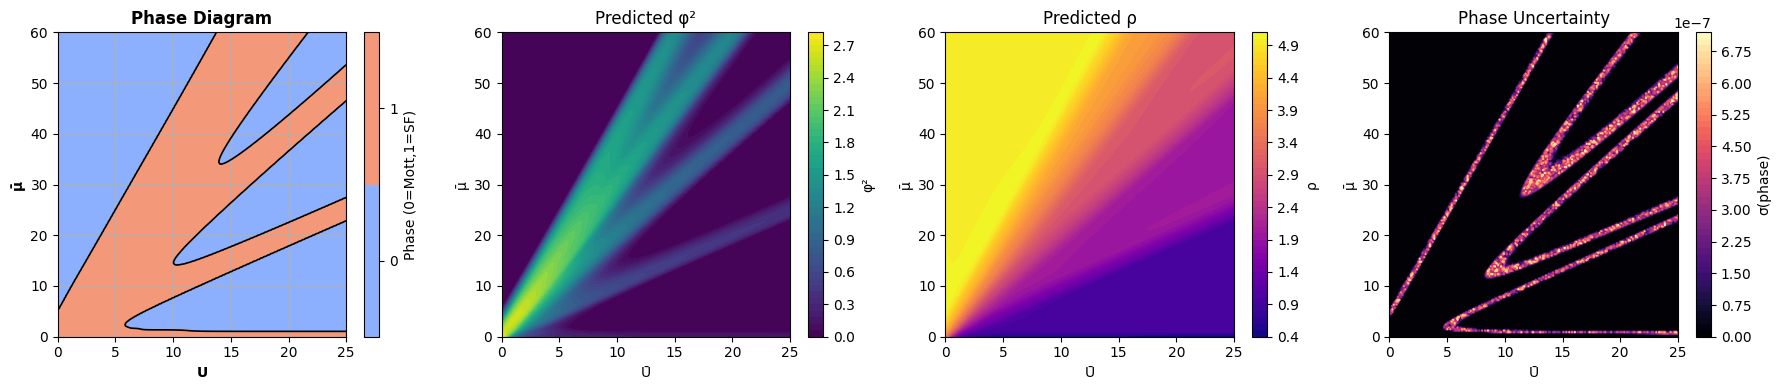

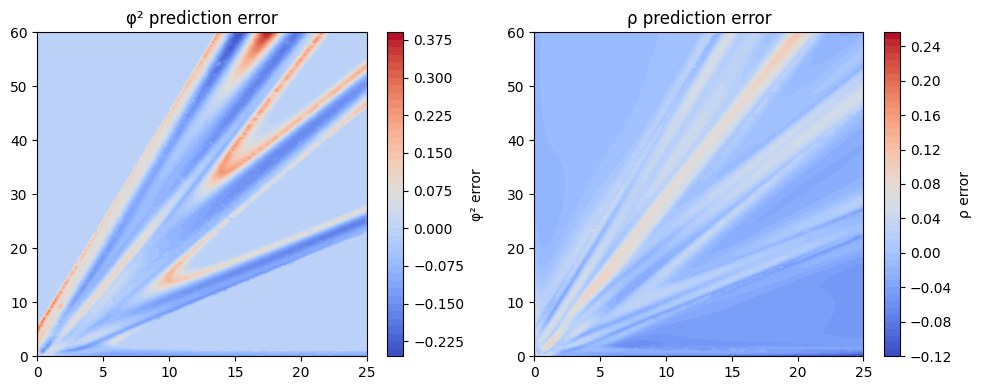

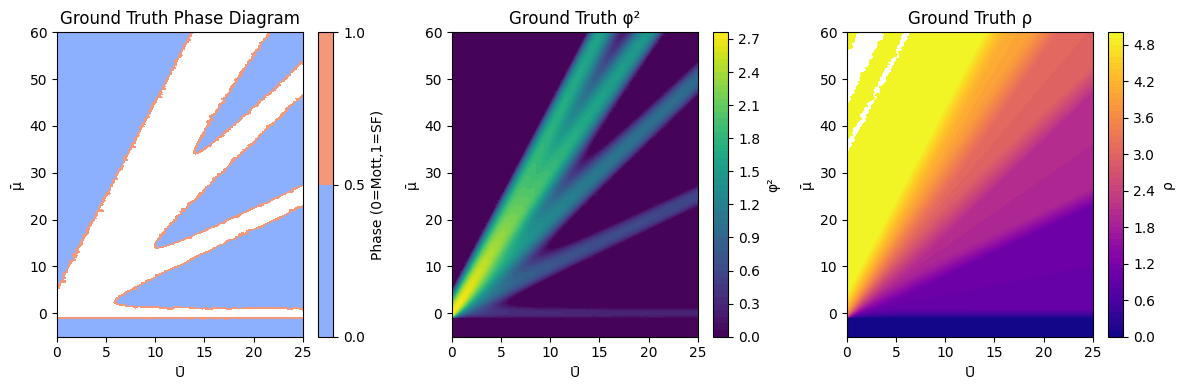


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9825    0.9966    0.9895     22889
           1     0.9954    0.9763    0.9857     17111

    accuracy                         0.9879     40000
   macro avg     0.9889    0.9864    0.9876     40000
weighted avg     0.9880    0.9879    0.9879     40000



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(15000, len(df_MI))             # cap deep MI
n_SF = min(15000, len(df_SF))             # cap deep SF
n_boundary = min(30000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('30k-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 30k extra

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

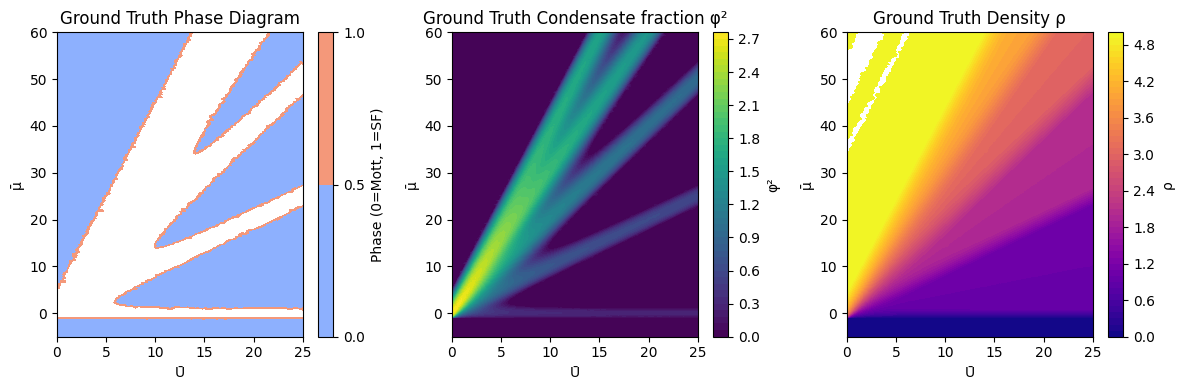

Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6988 - val_loss: 1.3381
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2226 - val_loss: 1.3263
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9991 - val_loss: 1.1889
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8801 - val_loss: 0.9535
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7748 - val_loss: 0.9033
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6543 - val_loss: 0.7205
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5326 - val_loss: 0.5365
Epoch 8/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4154 - val_loss: 0.4035
Epoch 9/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3536 - val_loss: 0.3095
Epoch 10/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3111 - val_loss: 0.2823
Epoch 11/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2871 - val_loss: 0.2125
Epoch 12/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2

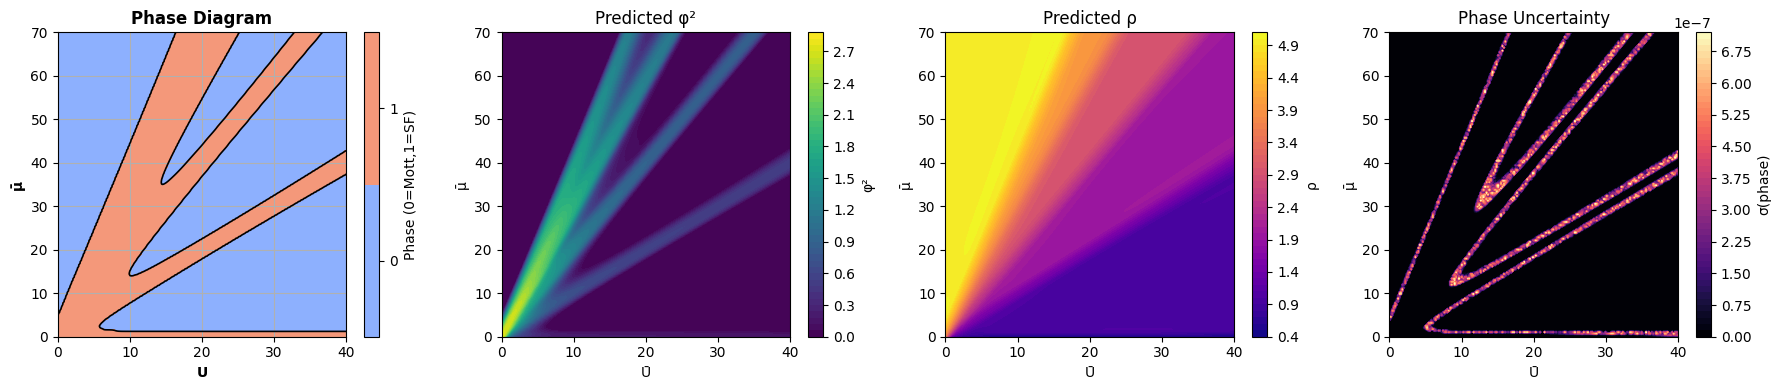

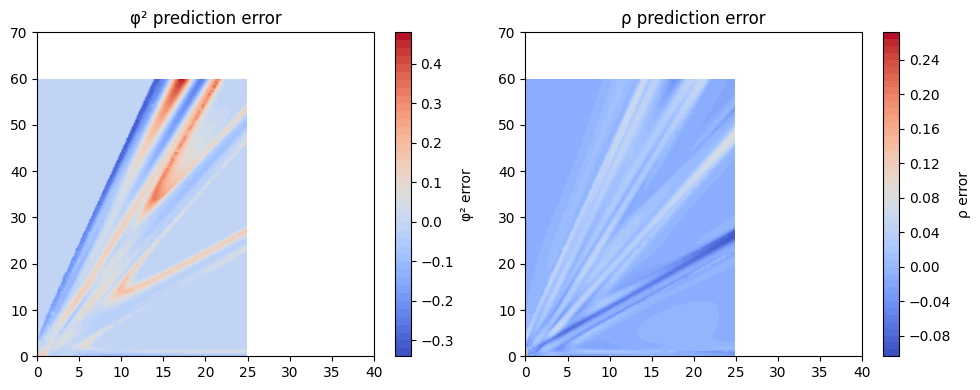

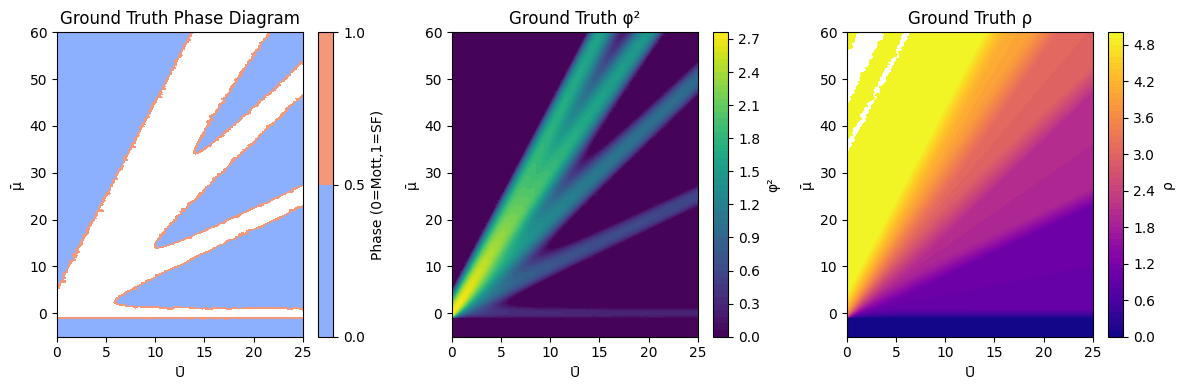


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9893    0.8816    0.9324     30823
           1     0.7088    0.9680    0.8184      9177

    accuracy                         0.9014     40000
   macro avg     0.8491    0.9248    0.8754     40000
weighted avg     0.9249    0.9014    0.9062     40000



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(15000, len(df_MI))             # cap deep MI
n_SF = min(15000, len(df_SF))             # cap deep SF
n_boundary = min(30000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('30k-extra-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 10k


          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

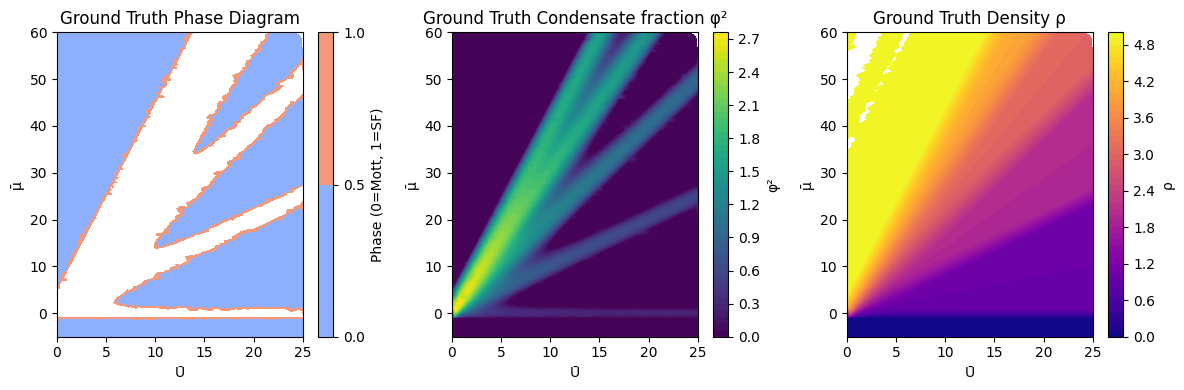

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5319 - val_loss: 1.2708
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4342 - val_loss: 1.0777
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7513 - val_loss: 1.1338
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4880 - val_loss: 1.0945
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3103 - val_loss: 1.0857
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2240 - val_loss: 1.1224
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1551 - val_loss: 1.1101
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1231 - val_loss: 1.0507
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0787 - val_loss: 1.0257
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0520 - val_loss: 1.0054
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9873 - val_loss: 0.9990
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

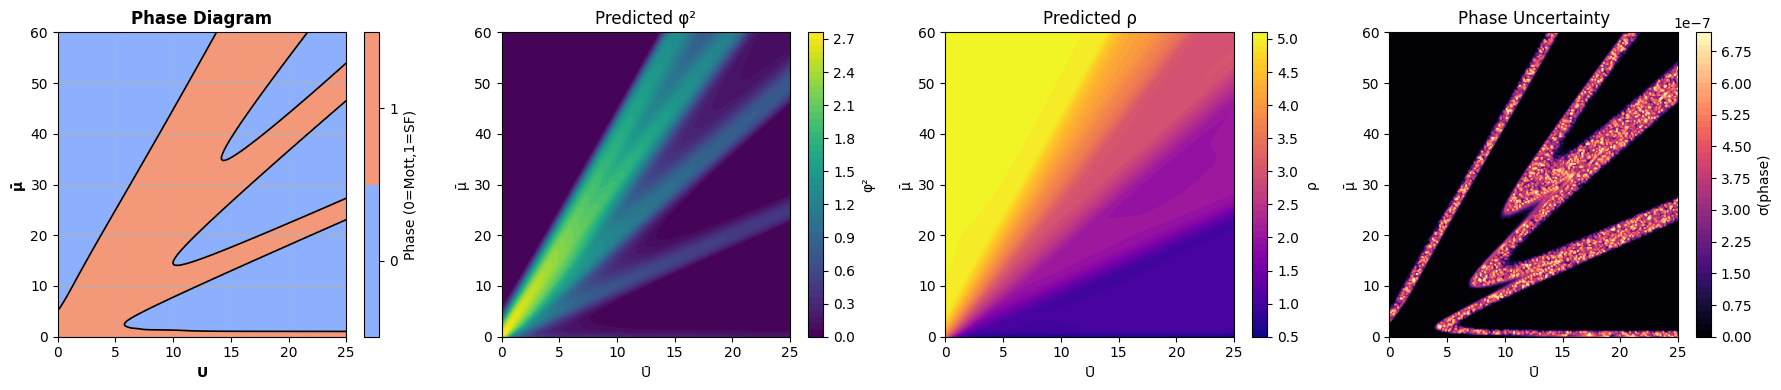

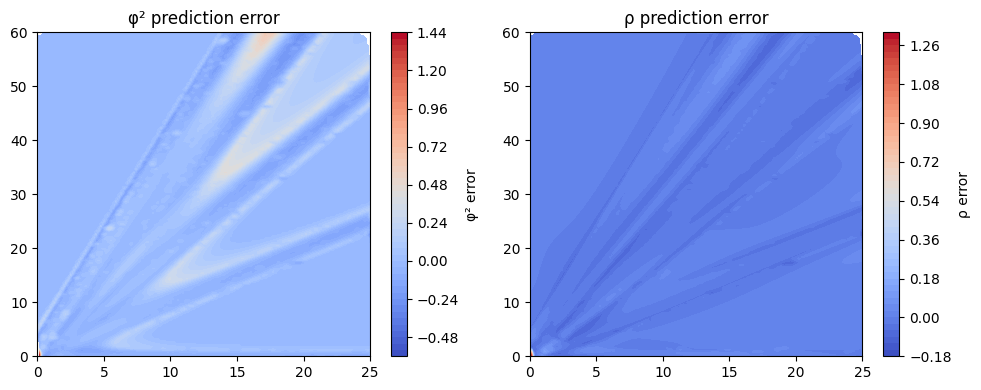

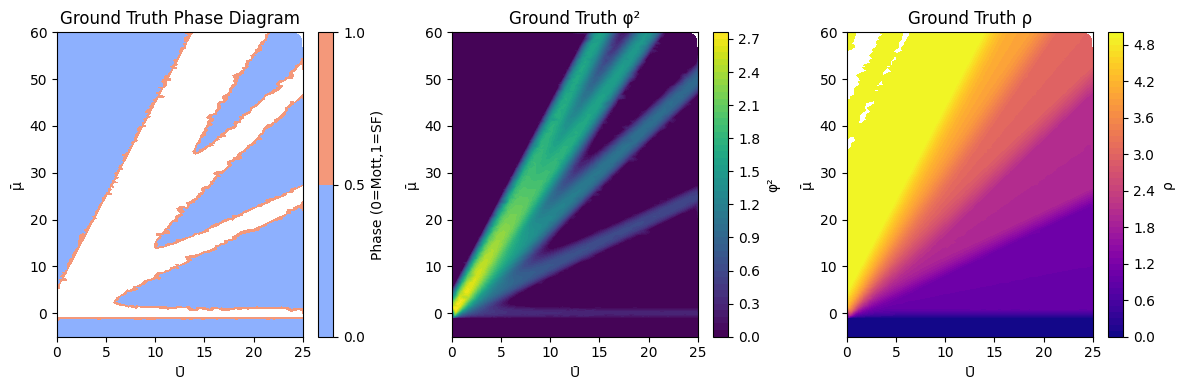


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9634    0.9965    0.9797     22564
           1     0.9953    0.9510    0.9726     17436

    accuracy                         0.9767     40000
   macro avg     0.9793    0.9737    0.9761     40000
weighted avg     0.9773    0.9767    0.9766     40000



In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(5000, len(df_MI))             # cap deep MI
n_SF = min(5000, len(df_SF))             # cap deep SF
n_boundary = min(10000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('10k-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 10k extra

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

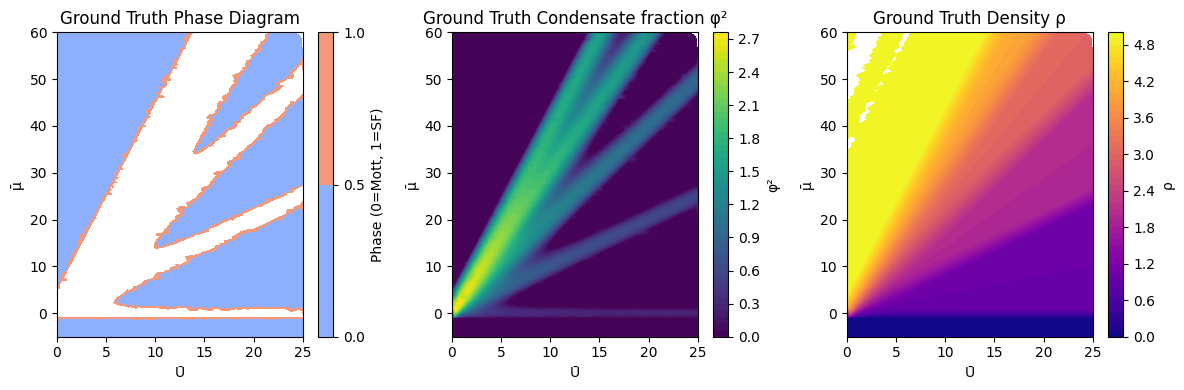

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 10.5545 - val_loss: 1.3028
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4605 - val_loss: 0.9370
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8123 - val_loss: 0.9938
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0311 - val_loss: 1.0063
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6282 - val_loss: 1.1218
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4580 - val_loss: 1.1760
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3469 - val_loss: 1.2831
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2460 - val_loss: 1.2319
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2148 - val_loss: 1.2555
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1597 - val_loss: 1.2175
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1101 - val_loss: 1.2588
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1

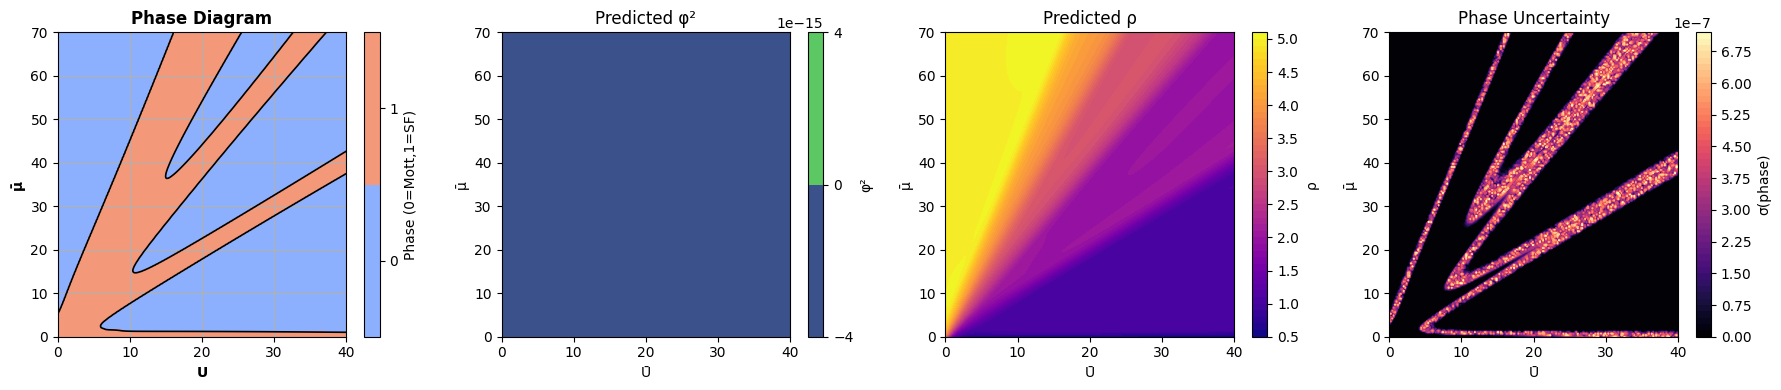

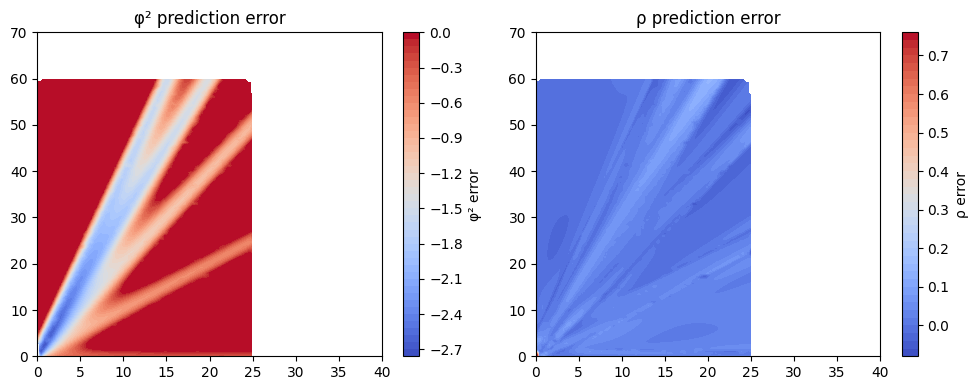

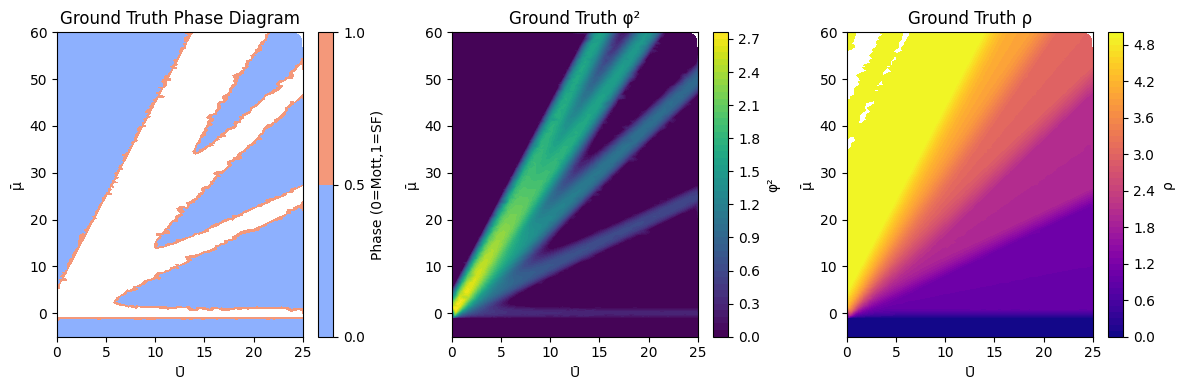


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9929    0.8693    0.9270     30683
           1     0.6948    0.9795    0.8129      9317

    accuracy                         0.8950     40000
   macro avg     0.8438    0.9244    0.8700     40000
weighted avg     0.9235    0.8950    0.9004     40000



In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(5000, len(df_MI))             # cap deep MI
n_SF = min(5000, len(df_SF))             # cap deep SF
n_boundary = min(10000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('10k-extra-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 6k

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

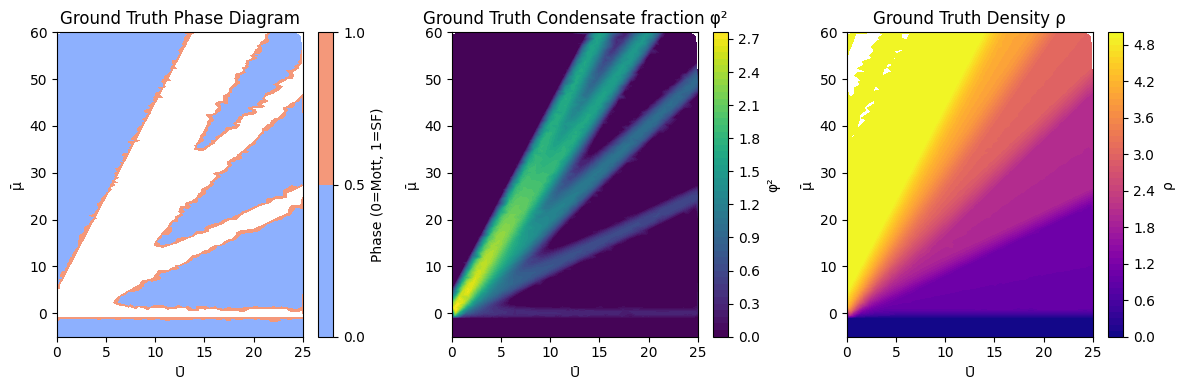

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.8859 - val_loss: 1.3111
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1297 - val_loss: 1.2987
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7128 - val_loss: 1.0769
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7703 - val_loss: 1.1077
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1992 - val_loss: 1.1636
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8299 - val_loss: 1.0796
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6164 - val_loss: 1.0558
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4536 - val_loss: 1.0339
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3370 - val_loss: 1.0581
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2769 - val_loss: 1.0083
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2041 - val_loss: 1.0649
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.

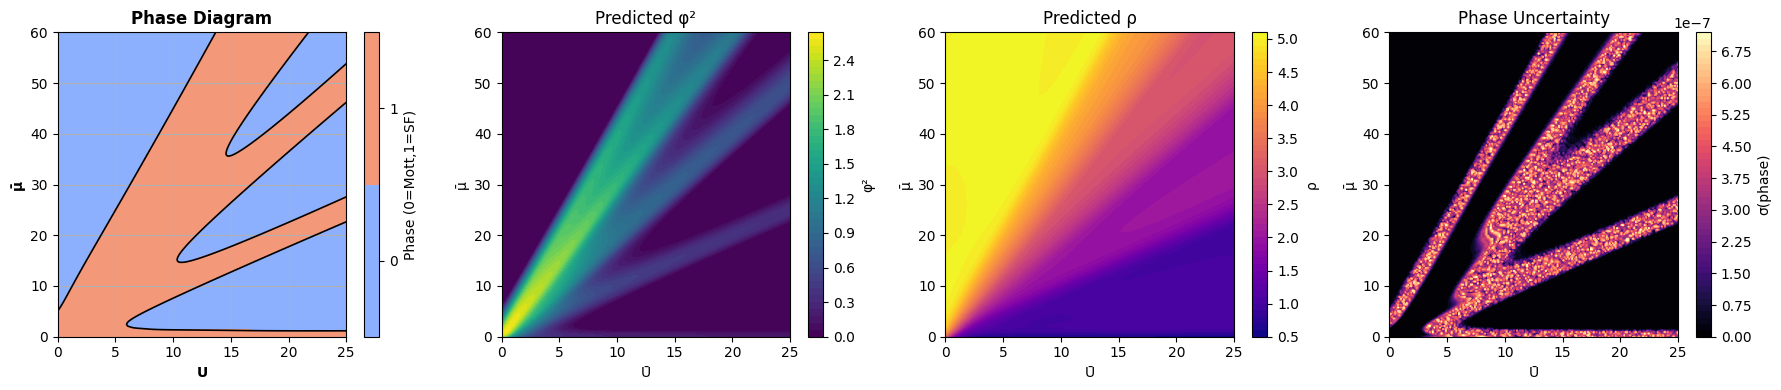

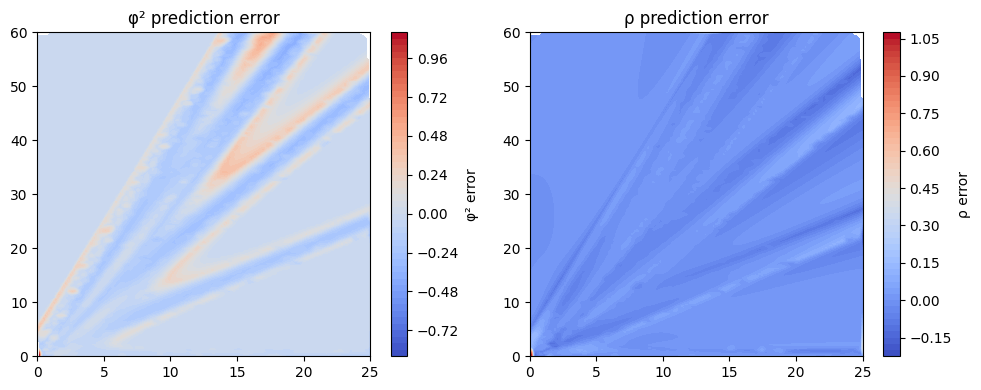

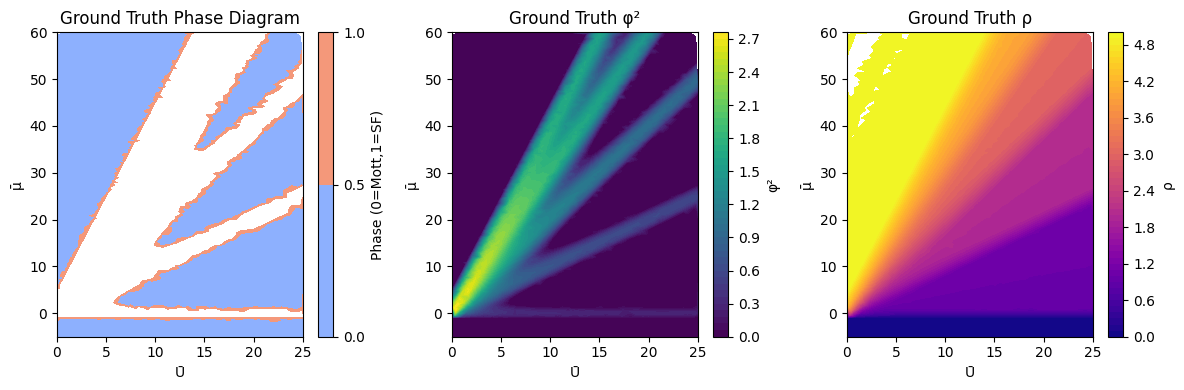


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9641    0.9905    0.9771     22256
           1     0.9876    0.9537    0.9704     17744

    accuracy                         0.9741     40000
   macro avg     0.9758    0.9721    0.9737     40000
weighted avg     0.9745    0.9741    0.9741     40000



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(3000, len(df_MI))             # cap deep MI
n_SF = min(3000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('6k-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 6k extrapolated region

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

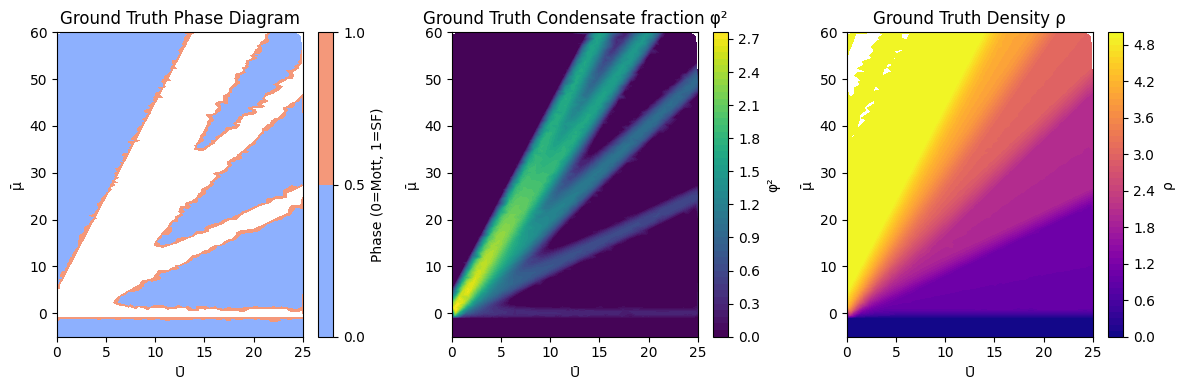

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.6612 - val_loss: 1.1870
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5820 - val_loss: 1.2904
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0570 - val_loss: 0.9910
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1347 - val_loss: 1.1435
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6740 - val_loss: 1.0093
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5041 - val_loss: 1.0944
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3506 - val_loss: 1.0149
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2791 - val_loss: 1.0812
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2308 - val_loss: 1.1404
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1881 - val_loss: 1.0725
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1500 - val_loss: 1.1222
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

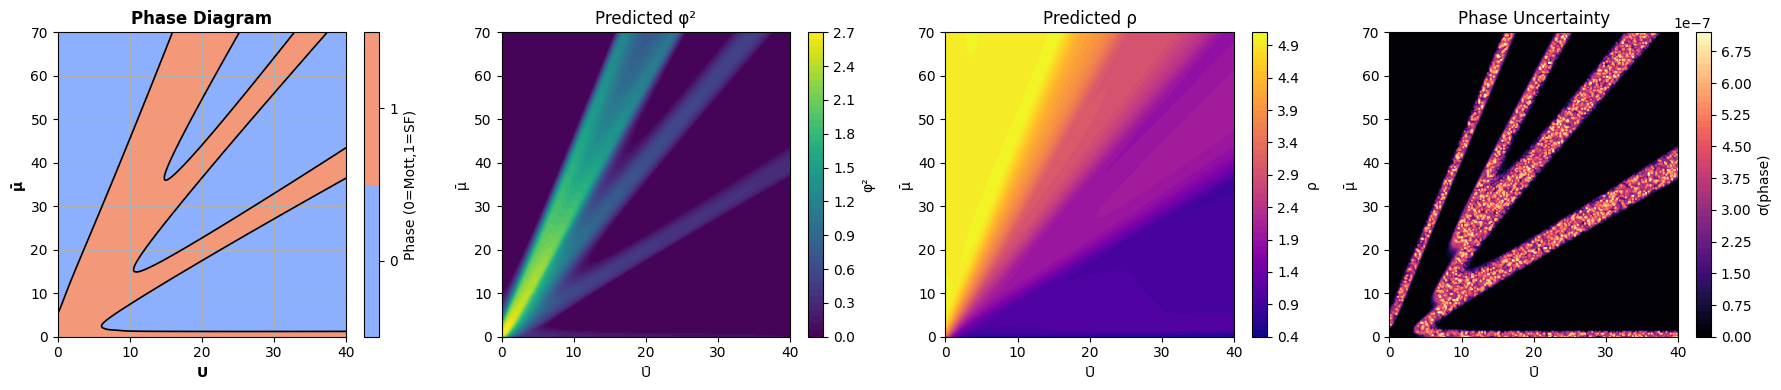

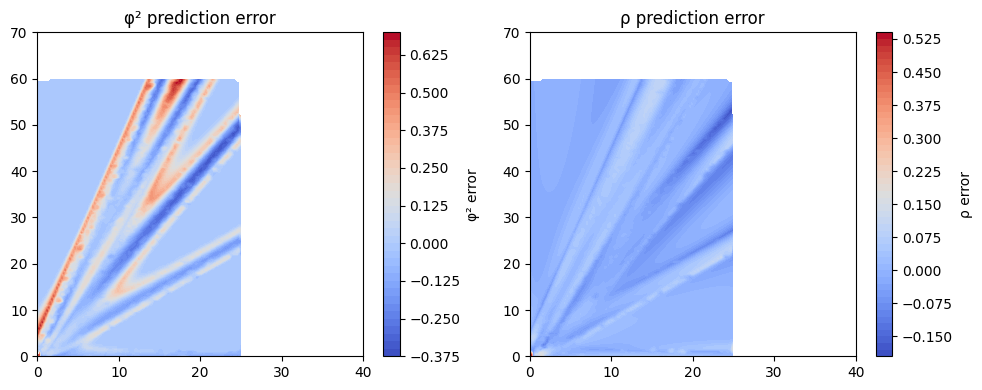

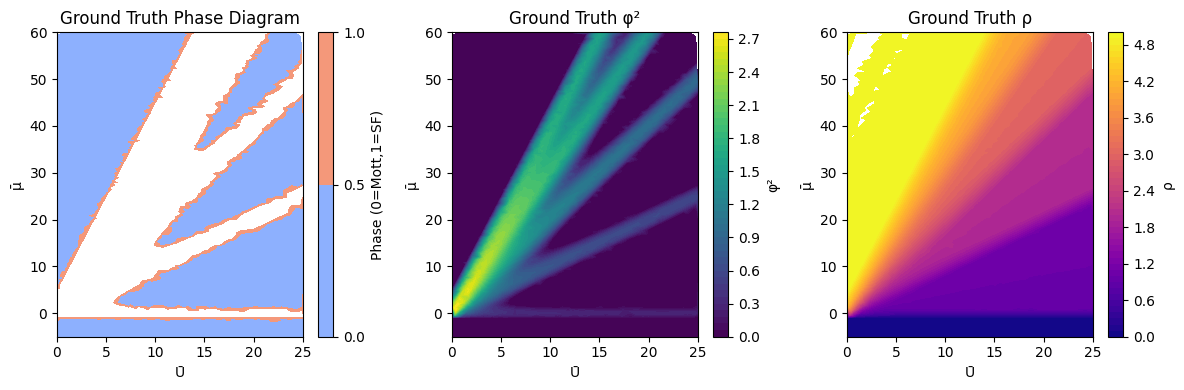


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9899    0.8602    0.9205     30540
           1     0.6828    0.9718    0.8020      9460

    accuracy                         0.8865     40000
   macro avg     0.8364    0.9160    0.8613     40000
weighted avg     0.9173    0.8865    0.8925     40000



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(3000, len(df_MI))             # cap deep MI
n_SF = min(3000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 70, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('6k-extra-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 4k

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

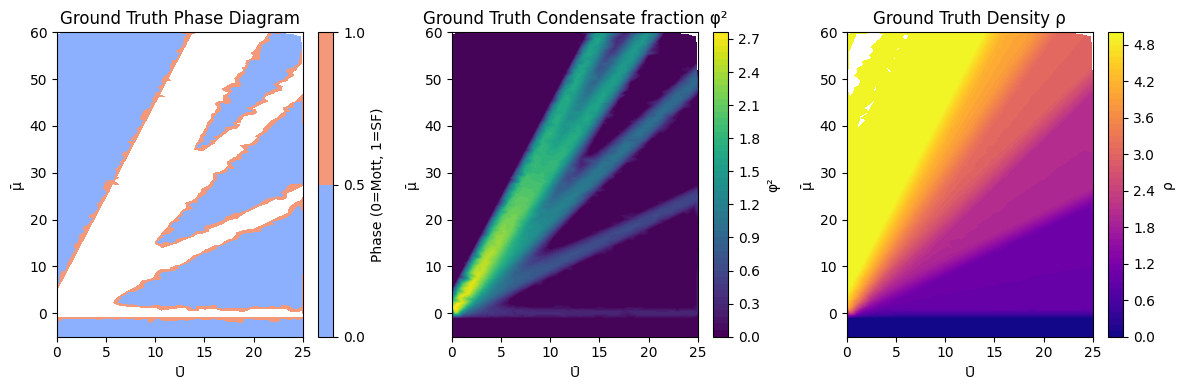

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.8959 - val_loss: 2.2470
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0694 - val_loss: 0.9748
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5476 - val_loss: 0.7744
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3091 - val_loss: 1.0526
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7467 - val_loss: 1.0054
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3810 - val_loss: 0.8540
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1272 - val_loss: 0.9142
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9271 - val_loss: 0.9212
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7489 - val_loss: 0.8652
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6020 - val_loss: 0.9091
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5015 - val_loss: 0.8636
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4385 - val_loss:

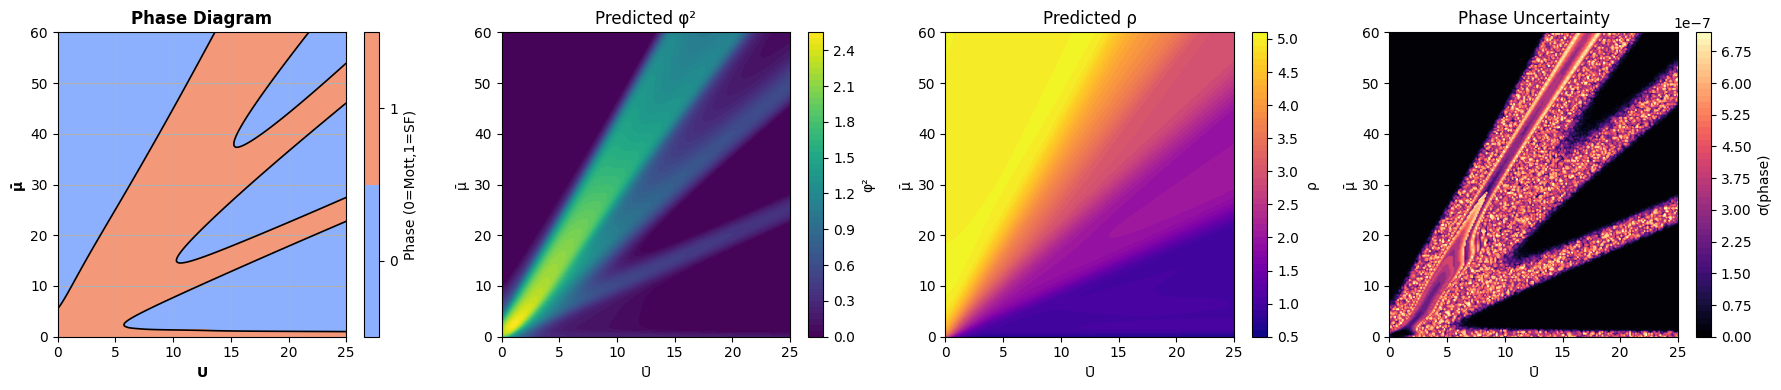

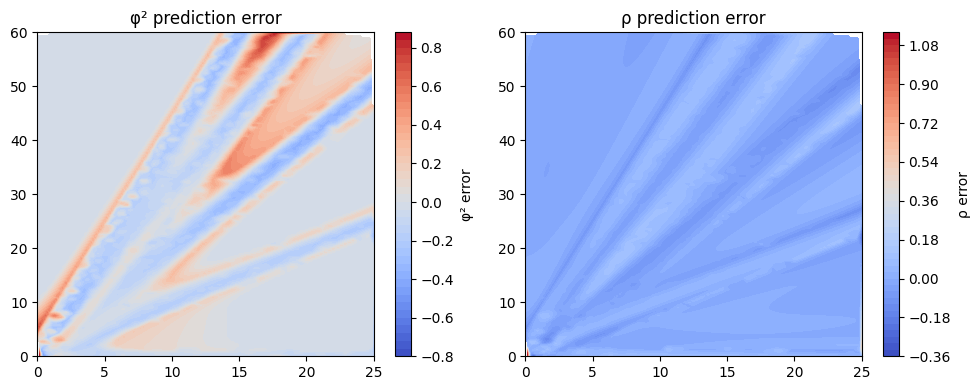

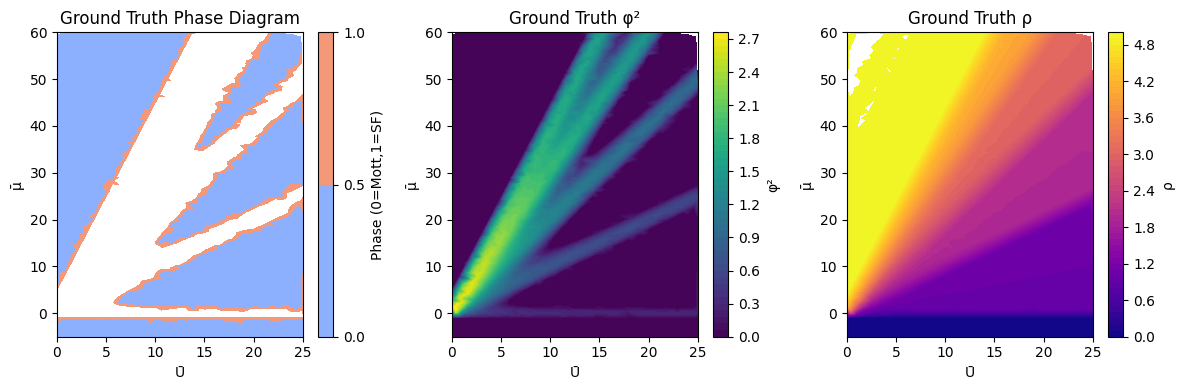


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9520    0.9893    0.9703     21976
           1     0.9863    0.9392    0.9622     18024

    accuracy                         0.9667     40000
   macro avg     0.9692    0.9643    0.9663     40000
weighted avg     0.9675    0.9667    0.9667     40000



In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(4000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('4k-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



# 4k Extrapolated region

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

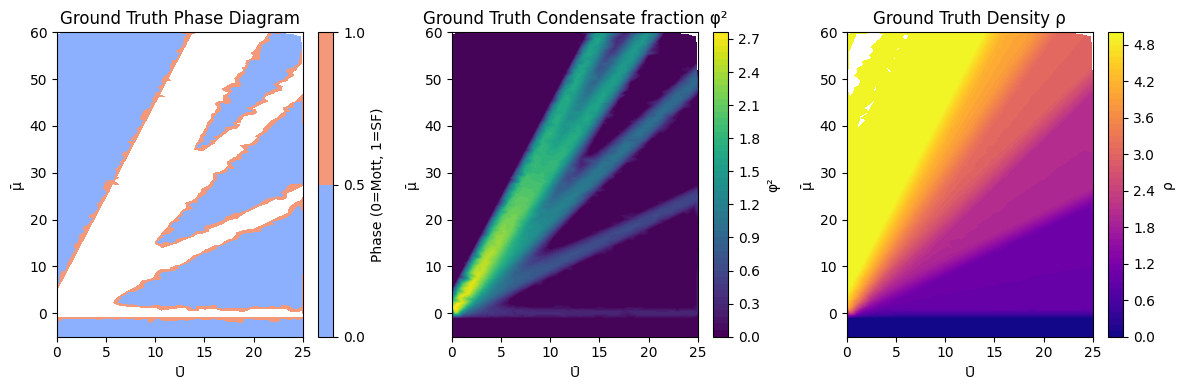

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 10.3686 - val_loss: 2.0808
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2515 - val_loss: 1.0379
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7849 - val_loss: 1.0832
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5259 - val_loss: 0.9735
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8173 - val_loss: 0.8606
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3705 - val_loss: 1.0358
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0603 - val_loss: 0.9209
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8943 - val_loss: 0.9600
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7745 - val_loss: 0.9019
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6382 - val_loss: 0.9033
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5036 - val_loss: 0.8848
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4449 - val_loss

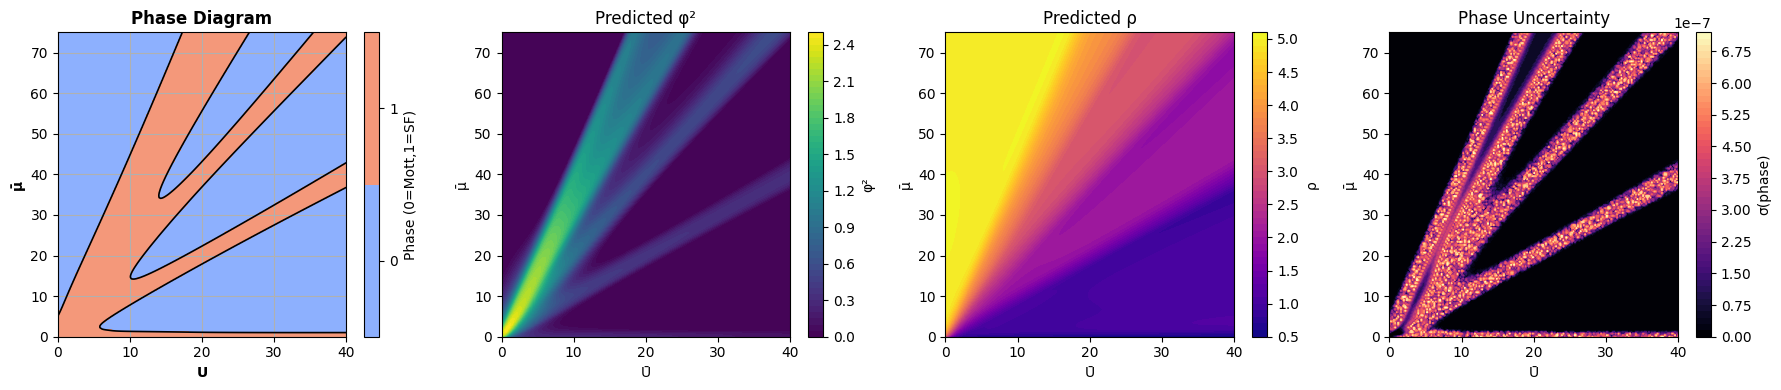

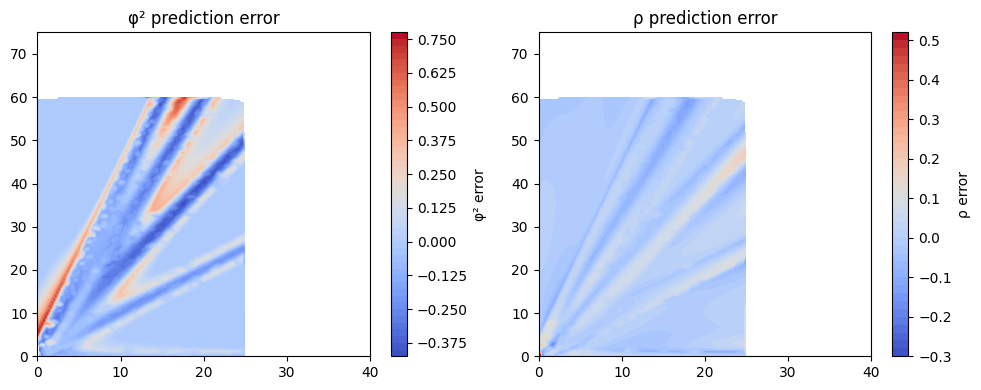

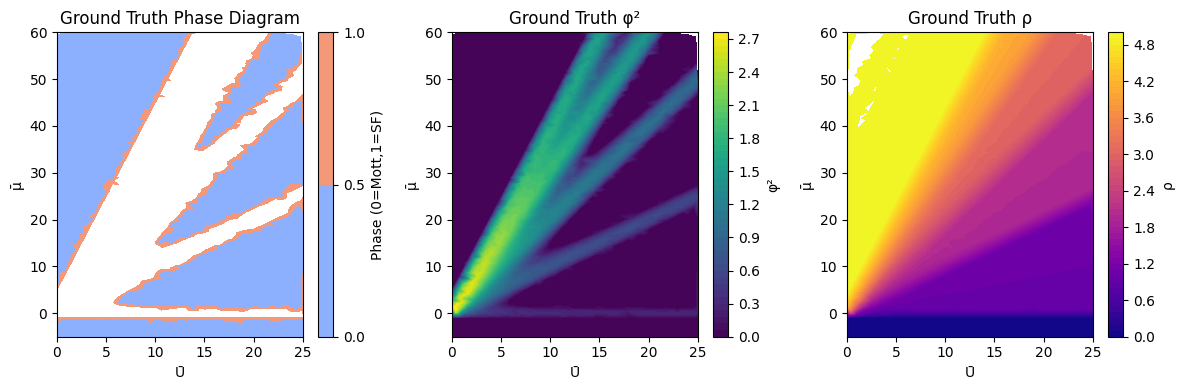


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9677    0.8571    0.9091     31015
           1     0.6464    0.9014    0.7529      8985

    accuracy                         0.8671     40000
   macro avg     0.8071    0.8793    0.8310     40000
weighted avg     0.8956    0.8671    0.8740     40000



In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superflud

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # --- 1) Load dataset ---
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Phase label
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

# print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

#------------------------------
#Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(4000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 40, 200)   # Ū axis
mu_vals = np.linspace(0, 75, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
# plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title("Phase Diagram",fontsize=12, fontweight="bold")
plt.grid(True)
plt.savefig('4k-extrapolated-Pinn-bayesian', dpi=300, bbox_inches='tight')


# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))

